In [1]:
import time
import hydroeval as he
import numpy as np
import pandas as pd
import json
import matplotlib.pyplot as plt
import sys
sys.path.insert(0, './CFE')
import bmi_cfe_open
import bmi_cfe_enkf_peturb
#import bmi_cfe_peturb

sys.path.insert(0, './Assimilation')
import Bmi_da_ENKF_forSBMI

#sys.path.append('/home/jovyan/data/NextGen---The-Simulators-/USGS/USGS_BMI_FT/cleaned_FT')
sys.path.append('../USGS/USGS_BMI_FT')
import bmi_usgs

#new bmi_cfe is CFE open and cfe peturb

In [2]:
print(bmi_cfe_open)
#print(bmi_cfe_peturb)
print(bmi_cfe_enkf_peturb)
print(Bmi_da_ENKF_forSBMI)
print(bmi_usgs)


<module 'bmi_cfe_open' from 'C:\\Users\\zjbut\\Documents\\GitHub\\NextGen---The-Simulators-\\Toy_Model\\./CFE\\bmi_cfe_open.py'>
<module 'bmi_cfe_enkf_peturb' from 'C:\\Users\\zjbut\\Documents\\GitHub\\NextGen---The-Simulators-\\Toy_Model\\./CFE\\bmi_cfe_enkf_peturb.py'>
<module 'Bmi_da_ENKF_forSBMI' from 'C:\\Users\\zjbut\\Documents\\GitHub\\NextGen---The-Simulators-\\Toy_Model\\./Assimilation\\Bmi_da_ENKF_forSBMI.py'>
<module 'bmi_usgs' from 'C:\\Users\\zjbut\\Documents\\GitHub\\NextGen---The-Simulators-\\Toy_Model\\../USGS/USGS_BMI_FT\\bmi_usgs.py'>


In [3]:
## Open BMI's for each file
# cfe_open = bmi_cfe.BMI_CFE()
# cfe_peturbed = bmi_cfe_peturb.BMI_CFE()
# cfe_analysis = bmi_cfe_statevars.BMI_CFE() #true model in the end with updated state vars

cfe_open = bmi_cfe_open.BMI_CFE()
cfe_peturbed = bmi_cfe_enkf_peturb.BMI_CFE()
cfe_analysis = bmi_cfe_enkf_peturb.BMI_CFE() #true model in the end with updated state vars
#cfe_analysis = bmi_cfe_statevars_et.BMI_CFE(

enkf = Bmi_da_ENKF_forSBMI.EnKF_wrap()
usgs = bmi_usgs.BMI_USGS()

In [4]:
## Initialize the BMI's
#cfe_open.initialize(cfg_file='./CFE/cat_58_config_cfe.json')
#cfe_peturbed.initialize(cfg_file='./CFE/cat_58_config_cfe_peturb_model.json')
#cfe_analysis.initialize(cfg_file='./CFE/cat_58_config_cfe.json') # I am confused what this config file should look like

# make one bmi for all of this and options in config file

# ## Case study files
cfe_open.initialize(cfg_file='./CFE/config_cfe_peturb_model_CT_calibration.json')
cfe_peturbed.initialize(cfg_file='./CFE/config_cfe_peturb_model_CT_calibration.json')
cfe_analysis.initialize(cfg_file='./CFE/config_cfe_peturb_model_CT_calibration.json')

enkf.initialize(cfg_file='./Assimilation/EnKF_config.json') # Need to create this still
usgs.initialize(cfg_file='../USGS/USGS_BMI_FT/usgs_config.json')



initialized 84.21526
                         Date     Flow  validity
0   2017-05-15 04:00:00+00:00  166.500       1.0
1   2017-05-15 05:00:00+00:00  161.000       1.0
2   2017-05-15 06:00:00+00:00  156.750       1.0
3   2017-05-15 07:00:00+00:00  151.500       1.0
4   2017-05-15 08:00:00+00:00  148.750       1.0
..                        ...      ...       ...
763 2017-06-15 23:00:00+00:00   28.400       1.0
764 2017-06-16 00:00:00+00:00   28.175       1.0
765 2017-06-16 01:00:00+00:00   28.400       1.0
766 2017-06-16 02:00:00+00:00   27.500       1.0
767 2017-06-16 03:00:00+00:00   27.500       1.0

[768 rows x 3 columns]
USGS station ID 01123000


                time  APCP_surface  RAINRATE      T2D       Q2D     U2D  \
0     5/15/2017 0:00           0.0       0.0  284.078  0.006616  6.0804   
1     5/15/2017 1:00           0.0       0.0  283.180  0.006650  6.0304   
2     5/15/2017 2:00           0.0       0.0  282.440  0.006614  5.9856   
3     5/15/2017 3:00           0.0       0.0  281.662  0.006476  5.9402   
4     5/15/2017 4:00           0.0       0.0  281.702  0.006530  6.3688   
..               ...           ...       ...      ...       ...     ...   
763  6/15/2017 19:00           0.0       0.0  295.270  0.007334 -1.1600   
764  6/15/2017 20:00           0.0       0.0  294.610  0.006788 -1.2230   
765  6/15/2017 21:00           0.0       0.0  293.624  0.006776 -1.2812   
766  6/15/2017 22:00           0.0       0.0  292.722  0.006714 -1.5682   
767  6/15/2017 23:00           0.0       0.0  291.554  0.006650 -1.8486   

        V2D       PSFC   SWDOWN   LWDOWN  
0   -1.9670   98376.98    0.000  318.822  
1   -2.0740  

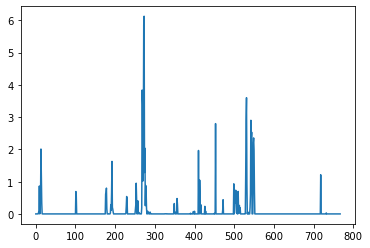

In [5]:
with open(cfe_open.forcing_file, 'r') as f:
    df_forcing = pd.read_csv(f)
    
print(df_forcing)
plt.plot(df_forcing['APCP_surface'])

values = df_forcing['APCP_surface']
print(values)

In [6]:
#Originial Version 
# basian coupling numerical error:
# the distrbutions are not well calibrated
# valibrate the model
# calibrate the pert
# set b matrix right: cov matrix in the peterbations.
# 2x2 matrix
# ground_water_storage_m 
# ground_water_storage_m <



#Make empty matrices for plotting
cfeOpen = []
cfePeturbed = []
cfeAnalysis = []
cfeEnKF = []
cfe_def = []

## Loop through time. Set values for each model and get values
for i, precip in enumerate(df_forcing['APCP_surface']): #i is RAINRATE

    # Set values for each model
    cfe_open.set_value('atmosphere_water__time_integral_of_precipitation_mass_flux', precip*0+6) #value of precip from forcing data in loop
    cfe_peturbed.set_value('atmosphere_water__time_integral_of_precipitation_mass_flux', precip*0+6)
    cfe_analysis.set_value('atmosphere_water__time_integral_of_precipitation_mass_flux', precip*0+6)
    
    # Update usgs data and get value to put into EnKF
    usgs.update()
    obs = np.array(usgs.get_value('Flow')) #need array for EnKf function. should get this when initialize. CFS 
    #obs_m = (obs * 3.281**3) #converting cfs to m3/s
    #print(obs_m)
    validity=usgs.get_value('validity')[i]
    print("-------------------------------------------------")
    print("validity",validity)

    # Update CFE open and peturbed. Get value for peturbed stats. 
    cfe_open.update()
    cfe_peturbed.update()
    
    # Get state variables originial values from CFE Analysis to update in enkf
    # Get state vars from Peturbed. These are values as enkf uses
    soil_storage_avail = cfe_peturbed.get_value('soil_storage_avail_m')
    soil_reservoir_storage_deficit = cfe_peturbed.get_value('soil_reservoir_storage_deficit_out_m')
    cfe_def.append(soil_reservoir_storage_deficit)
    storage_max_m= cfe_peturbed.get_value("storage_max_out_m")
    print(storage_max_m)
    
    print("DEF!!",cfe_peturbed.get_value("soil_reservoir_storage_deficit_out_m"))
    surface_runoff = cfe_peturbed.get_value('land_surface_water__runoff_volume_flux')
    # if surface_runoff>0:
    #     print("surface_runoff",surface_runoff)
    # Get values for plotting
    outflow = cfe_open.get_value('land_surface_water__runoff_depth') #m3/s
    cfeOpen.append(outflow) #for plotting
    outflow_peturb = cfe_peturbed.get_value('land_surface_water__runoff_depth_ens')
    
    # Get mean and covariance for stats of ensemble runs for EnKF
    outflow_peturb_mean = np.mean(outflow_peturb)
    outflow_peturb_covar = np.cov(outflow_peturb)
    #print("mean", outflow_peturb_mean)
    #print("covar", outflow_peturb_covar)
    cfePeturbed.append(outflow_peturb_mean) #for plotting
    # print(usgs.get_value('validity')[0])


    # Set EnKF value to usgs, mean, and covariance. Get value from it then
    enkf.set_value('soil_storage_avail_m', soil_storage_avail) #setting soil storage in enkf
    enkf.set_value('soil_reservoir_storage_deficit_m', soil_reservoir_storage_deficit) #setting soil storage in enkf
    enkf.set_value('surface_runoff_depth_m', surface_runoff) #setting soil storage in enkf   
    enkf.set_value('storage_max_m',storage_max_m)
    print("enkf.set_value('storage_max_m',storage_max_m)")
    enkf.set_value('x', np.array([outflow_peturb_mean]))
    enkf.set_value('P', np.array([outflow_peturb_covar]))
    enkf.set_value('z', np.array([obs[i]]))
    enkf_validity=enkf.set_value('validity',validity)
    enkf.update()


    #For plotting############################# after this
    outflow_enkf = enkf.get_value('enkf')
    cfeEnKF.append(outflow_enkf)

    state_transition_soil_storage = enkf.get_value('soil_storage_avail_m')
    state_transition_soil_res     = enkf.get_value('soil_reservoir_storage_deficit_updated_m')
    # state_transition_runoff       = enkf.get_value('surface_runoff_depth_updated_m')
    state_transition_runoff_factor= enkf.get_value('surface_runoff_ratio')
    # print("Updated deficit",state_transition_soil_res)


#     # Set value for CFE analysis based on the state variable change from the EnKF factor tog et true streamflow
    cfe_analysis.set_value('soil_storage_avail_m', state_transition_soil_storage) #look up value from lookup table based on EnKF factor   
    cfe_analysis.set_value('soil_reservoir_storage_deficit_m', state_transition_soil_res) #look up value from lookup table based on EnKF factor   
    # cfe_analysis.set_value('DIRECT_RUNOFF', state_transition_runoff) 
    cfe_analysis.set_value('state_var_change_runoff',state_transition_runoff_factor)

    cfe_analysis.update() #get new streamflow value based on state var change
    # set them in to pert
    outflow_analysis = cfe_analysis.get_value('land_surface_water__runoff_depth')
    cfeAnalysis.append(outflow_analysis) #for plotting
        
     # Update final model from value of analysis
    cfe_updated_everything_soil_storage = cfe_analysis.get_value('soil_storage_avail_m')
    cfe_updated_everything_soil_res = cfe_analysis.get_value('soil_reservoir_storage_deficit_m')
    print("should be Updated deficit",cfe_updated_everything_soil_res)
    cfe_updated_everything_runoff = cfe_analysis.get_value('state_var_change_runoff')

    cfe_peturbed.set_value('soil_storage_avail_m', cfe_updated_everything_soil_storage)
    cfe_peturbed.set_value('soil_reservoir_storage_deficit_m', cfe_updated_everything_soil_res)
    cfe_peturbed.set_value('state_var_change_runoff', cfe_updated_everything_runoff)
    # cfe_peturbed.update()
 
# # Finalize models
cfe_open.finalize(print_mass_balance=True)
cfe_peturbed.finalize(print_mass_balance=True)
cfe_analysis.finalize(print_mass_balance=True)
usgs.finalize()
enkf.finalize()

-------------------------------------------------
validity 1.0
1.0209454943333334
DEF!! 0.33997484961299995
enkf.set_value('storage_max_m',storage_max_m)
Beginning----------------------------
self.f 100.0
soil_storage_deficit_from CFE 0.33997484961299995
EnKF Code predicted, X Post [166.65520684]
***********under estimaiton ratio [4.10025125]
Observation BMI [166.5]
CFE [40.64512064]
enkf [166.65520684]
should be Updated deficit 0
-------------------------------------------------
validity 1.0
1.0209454943333334
DEF!! 0.09183353053238519
enkf.set_value('storage_max_m',storage_max_m)
Beginning----------------------------
self.f 100.0
soil_storage_deficit_from CFE 0.09183353053238519
EnKF Code predicted, X Post [161.02816587]
surface_runoff_ratio [75.5170662]
Leftover vol [162.77360523]
surface _runoff [75.5170662]
***********over estimaiton ratio [0.49730477]
Observation BMI [161.]
CFE [323.80177111]
enkf [161.02816587]
should be Updated deficit 0
----------------------------------------

Leftover vol [43.0934586]
surface _runoff [49.19960591]
***********over estimaiton ratio [0.6656245]
Observation BMI [85.825]
CFE [128.87744183]
enkf [85.78398323]
should be Updated deficit 0
-------------------------------------------------
validity 1.0
1.0209454943333334
DEF!! 0.02073693050135894
enkf.set_value('storage_max_m',storage_max_m)
Beginning----------------------------
self.f 100.0
soil_storage_deficit_from CFE 0.02073693050135894
EnKF Code predicted, X Post [85.90527871]
***********under estimaiton ratio [1.16228014]
Observation BMI [85.5]
CFE [73.91099243]
enkf [85.90527871]
should be Updated deficit 0
-------------------------------------------------
validity 1.0
1.0209454943333334
DEF!! 0.02073693050135894
enkf.set_value('storage_max_m',storage_max_m)
Beginning----------------------------
self.f 100.0
soil_storage_deficit_from CFE 0.02073693050135894
EnKF Code predicted, X Post [84.56414786]
surface_runoff_ratio [62.36896735]
Leftover vol [29.01668228]
surface _runoff [

1.0209454943333334
DEF!! 0.02073693050135894
enkf.set_value('storage_max_m',storage_max_m)
Beginning----------------------------
self.f 100.0
soil_storage_deficit_from CFE 0.02073693050135894
EnKF Code predicted, X Post [61.7196799]
***********under estimaiton ratio [1.03722035]
Observation BMI [62.025]
CFE [59.50488715]
enkf [61.7196799]
should be Updated deficit 0
-------------------------------------------------
validity 1.0
1.0209454943333334
DEF!! 0.02073693050135894
enkf.set_value('storage_max_m',storage_max_m)
Beginning----------------------------
self.f 100.0
soil_storage_deficit_from CFE 0.02073693050135894
EnKF Code predicted, X Post [61.81017038]
surface_runoff_ratio [47.20633509]
Leftover vol [29.12833382]
surface _runoff [47.20633509]
***********over estimaiton ratio [0.67969196]
Observation BMI [60.9]
CFE [90.9385042]
enkf [61.81017038]
should be Updated deficit 0
-------------------------------------------------
validity 1.0
1.0209454943333334
DEF!! 0.02073693050135894
e

EnKF Code predicted, X Post [41.89433411]
surface_runoff_ratio [28.77777934]
Leftover vol [37.7479633]
surface _runoff [28.77777934]
***********over estimaiton ratio [0.52603121]
Observation BMI [41.8]
CFE [79.64229741]
enkf [41.89433411]
should be Updated deficit 0
-------------------------------------------------
validity 1.0
1.0209454943333334
DEF!! 0.02073693050135894
enkf.set_value('storage_max_m',storage_max_m)
Beginning----------------------------
self.f 100.0
soil_storage_deficit_from CFE 0.02073693050135894
EnKF Code predicted, X Post [41.50510964]
surface_runoff_ratio [25.61552801]
Leftover vol [46.48044662]
surface _runoff [25.61552801]
***********over estimaiton ratio [0.4717264]
Observation BMI [41.8]
CFE [87.98555626]
enkf [41.50510964]
should be Updated deficit 0
-------------------------------------------------
validity 1.0
1.0209454943333334
DEF!! 0.02073693050135894
enkf.set_value('storage_max_m',storage_max_m)
Beginning----------------------------
self.f 100.0
soil_s

EnKF Code predicted, X Post [46.45404571]
surface_runoff_ratio [31.04479753]
Leftover vol [31.57828148]
surface _runoff [31.04479753]
***********over estimaiton ratio [0.59531796]
Observation BMI [46.3]
CFE [78.03232719]
enkf [46.45404571]
should be Updated deficit 0
-------------------------------------------------
validity 1.0
1.0209454943333334
DEF!! 0.02073693050135894
enkf.set_value('storage_max_m',storage_max_m)
Beginning----------------------------
self.f 100.0
soil_storage_deficit_from CFE 0.02073693050135894
EnKF Code predicted, X Post [45.34980173]
surface_runoff_ratio [28.14825475]
Leftover vol [39.37845825]
surface _runoff [28.14825475]
***********over estimaiton ratio [0.5352382]
Observation BMI [45.2]
CFE [84.72825998]
enkf [45.34980173]
should be Updated deficit 0
-------------------------------------------------
validity 1.0
1.0209454943333334
DEF!! 0.02073693050135894
enkf.set_value('storage_max_m',storage_max_m)
Beginning----------------------------
self.f 100.0
soil_

EnKF Code predicted, X Post [94.80549572]
surface_runoff_ratio [81.99917979]
Leftover vol 0.0
surface _runoff [81.99917979]
***********over estimaiton ratio [1.]
Observation BMI [95.2]
CFE [107.96845669]
enkf [94.80549572]
should be Updated deficit [0.00088116]
-------------------------------------------------
validity 1.0
1.0209454943333334
DEF!! 0.02073693050135894
enkf.set_value('storage_max_m',storage_max_m)
Beginning----------------------------
self.f 100.0
soil_storage_deficit_from CFE 0.02073693050135894
EnKF Code predicted, X Post [117.43041606]
surface_runoff_ratio [66.89550024]
Leftover vol [37.54863614]
surface _runoff [66.89550024]
***********over estimaiton ratio [0.75771799]
Observation BMI [117.25]
CFE [154.9790522]
enkf [117.43041606]
should be Updated deficit 0
-------------------------------------------------
validity 1.0
1.0209454943333334
DEF!! 0.02073693050135894
enkf.set_value('storage_max_m',storage_max_m)
Beginning----------------------------
self.f 100.0
soil_s

enkf.set_value('storage_max_m',storage_max_m)
Beginning----------------------------
self.f 100.0
soil_storage_deficit_from CFE 0.02073693050135894
EnKF Code predicted, X Post [nan]
 warning validity is zero
should be Updated deficit 0.02073693050135894
-------------------------------------------------
validity 1.0
1.0209454943333334
DEF!! 0.02073693050135894
enkf.set_value('storage_max_m',storage_max_m)
Beginning----------------------------
self.f 100.0
soil_storage_deficit_from CFE 0.02073693050135894
EnKF Code predicted, X Post [67.86510719]
surface_runoff_ratio [46.67381738]
Leftover vol [44.39713429]
surface _runoff [46.67381738]
***********over estimaiton ratio [0.604523]
Observation BMI [68.2]
CFE [112.26224149]
enkf [67.86510719]
should be Updated deficit 0
-------------------------------------------------
validity 0.0
1.0209454943333334
DEF!! 0.02073693050135894
enkf.set_value('storage_max_m',storage_max_m)
Beginning----------------------------
self.f 100.0
soil_storage_deficit

C:\Users\zjbut\Documents\GitHub\NextGen---The-Simulators-\Toy_Model\./Assimilation\EnKF.py:69: RuntimeWarning: invalid value encountered in floor_divide
  e.factor=e.res//e.x


[44.24955543]
***********over estimaiton ratio [0.56906088]
Observation BMI [65.4]
CFE [114.85852885]
enkf [65.36149564]
should be Updated deficit 0
-------------------------------------------------
validity 0.0
1.0209454943333334
DEF!! 0.02073693050135894
enkf.set_value('storage_max_m',storage_max_m)
Beginning----------------------------
self.f 100.0
soil_storage_deficit_from CFE 0.02073693050135894
EnKF Code predicted, X Post [nan]
 warning validity is zero
should be Updated deficit 0.02073693050135894
-------------------------------------------------
validity 1.0
1.0209454943333334
DEF!! 0.02073693050135894
enkf.set_value('storage_max_m',storage_max_m)
Beginning----------------------------
self.f 100.0
soil_storage_deficit_from CFE 0.02073693050135894
EnKF Code predicted, X Post [65.44886198]
surface_runoff_ratio [33.98507009]
Leftover vol [82.00449173]
surface _runoff [33.98507009]
***********over estimaiton ratio [0.44386147]
Observation BMI [64.4]
CFE [147.45335371]
enkf [65.4488

EnKF Code predicted, X Post [51.74162236]
surface_runoff_ratio [31.00650991]
Leftover vol [39.57755693]
surface _runoff [31.00650991]
***********over estimaiton ratio [0.56660192]
Observation BMI [52.6]
CFE [91.31917929]
enkf [51.74162236]
should be Updated deficit 0
-------------------------------------------------
validity 1.0
1.0209454943333334
DEF!! 0.02073693050135894
enkf.set_value('storage_max_m',storage_max_m)
Beginning----------------------------
self.f 100.0
soil_storage_deficit_from CFE 0.02073693050135894
EnKF Code predicted, X Post [52.00874924]
surface_runoff_ratio [30.00096481]
Leftover vol [40.7677454]
surface _runoff [30.00096481]
***********over estimaiton ratio [0.5605811]
Observation BMI [52.6]
CFE [92.77649464]
enkf [52.00874924]
should be Updated deficit 0
-------------------------------------------------
validity 1.0
1.0209454943333334
DEF!! 0.02073693050135894
enkf.set_value('storage_max_m',storage_max_m)
Beginning----------------------------
self.f 100.0
soil_s

1.0209454943333334
DEF!! 0.02073693050135894
enkf.set_value('storage_max_m',storage_max_m)
Beginning----------------------------
self.f 100.0
soil_storage_deficit_from CFE 0.02073693050135894
EnKF Code predicted, X Post [47.26261775]
surface_runoff_ratio [51.58607964]
Leftover vol 0.0
surface _runoff [51.58607964]
***********over estimaiton ratio [1.]
Observation BMI [47.5]
CFE [59.35172761]
enkf [47.26261775]
should be Updated deficit [0.00250102]
-------------------------------------------------
validity 1.0
1.0209454943333334
DEF!! 0.02073693050135894
enkf.set_value('storage_max_m',storage_max_m)
Beginning----------------------------
self.f 100.0
soil_storage_deficit_from CFE 0.02073693050135894
EnKF Code predicted, X Post [47.35788543]
surface_runoff_ratio [30.86666507]
Leftover vol [52.11412087]
surface _runoff [30.86666507]
***********over estimaiton ratio [0.47609259]
Observation BMI [47.5]
CFE [99.4720063]
enkf [47.35788543]
should be Updated deficit 0
-------------------------

surface_runoff_ratio [27.89563365]
Leftover vol [45.10084094]
surface _runoff [27.89563365]
***********over estimaiton ratio [0.51944628]
Observation BMI [48.45]
CFE [93.85181908]
enkf [48.75097815]
should be Updated deficit 0
-------------------------------------------------
validity 1.0
1.0209454943333334
DEF!! 0.02073693050135894
enkf.set_value('storage_max_m',storage_max_m)
Beginning----------------------------
self.f 100.0
soil_storage_deficit_from CFE 0.02073693050135894
EnKF Code predicted, X Post [50.80221337]
surface_runoff_ratio [31.11989072]
Leftover vol [33.77166846]
surface _runoff [31.11989072]
***********over estimaiton ratio [0.60068442]
Observation BMI [50.975]
CFE [84.57388183]
enkf [50.80221337]
should be Updated deficit 0
-------------------------------------------------
validity 1.0
1.0209454943333334
DEF!! 0.02073693050135894
enkf.set_value('storage_max_m',storage_max_m)
Beginning----------------------------
self.f 100.0
soil_storage_deficit_from CFE 0.02073693050

surface _runoff [98.55831918]
***********over estimaiton ratio [1.]
Observation BMI [130.5]
CFE [140.50620069]
enkf [130.74738301]
should be Updated deficit [0.00601616]
-------------------------------------------------
validity 1.0
1.0209454943333334
DEF!! 0.02073693050135894
enkf.set_value('storage_max_m',storage_max_m)
Beginning----------------------------
self.f 100.0
soil_storage_deficit_from CFE 0.02073693050135894
EnKF Code predicted, X Post [136.65984173]
surface_runoff_ratio [85.39201965]
Leftover vol [23.11407471]
surface _runoff [85.39201965]
***********over estimaiton ratio [0.85533261]
Observation BMI [136.25]
CFE [159.77391644]
enkf [136.65984173]
should be Updated deficit 0
-------------------------------------------------
validity 1.0
1.0209454943333334
DEF!! 0.02073693050135894
enkf.set_value('storage_max_m',storage_max_m)
Beginning----------------------------
self.f 100.0
soil_storage_deficit_from CFE 0.02073693050135894
EnKF Code predicted, X Post [144.46223869]
surf

EnKF Code predicted, X Post [89.0052846]
surface_runoff_ratio [60.75792587]
Leftover vol [31.66953101]
surface _runoff [60.75792587]
***********over estimaiton ratio [0.73756305]
Observation BMI [88.325]
CFE [120.6748156]
enkf [89.0052846]
should be Updated deficit 0
-------------------------------------------------
validity 1.0
1.0209454943333334
DEF!! 0.02073693050135894
enkf.set_value('storage_max_m',storage_max_m)
Beginning----------------------------
self.f 100.0
soil_storage_deficit_from CFE 0.02073693050135894
EnKF Code predicted, X Post [87.89707227]
surface_runoff_ratio [79.20654868]
Leftover vol 0.0
surface _runoff [79.20654868]
***********over estimaiton ratio [1.]
Observation BMI [87.4]
CFE [99.84835777]
enkf [87.89707227]
should be Updated deficit [0.00270892]
-------------------------------------------------
validity 1.0
1.0209454943333334
DEF!! 0.02073693050135894
enkf.set_value('storage_max_m',storage_max_m)
Beginning----------------------------
self.f 100.0
soil_storag

validity 1.0
1.0209454943333334
DEF!! 0.02073693050135894
enkf.set_value('storage_max_m',storage_max_m)
Beginning----------------------------
self.f 100.0
soil_storage_deficit_from CFE 0.02073693050135894
EnKF Code predicted, X Post [51.77970015]
surface_runoff_ratio [41.84236814]
Leftover vol [24.9017428]
surface _runoff [41.84236814]
***********over estimaiton ratio [0.67525725]
Observation BMI [51.3]
CFE [76.68144295]
enkf [51.77970015]
should be Updated deficit 0
-------------------------------------------------
validity 1.0
1.0209454943333334
DEF!! 0.02073693050135894
enkf.set_value('storage_max_m',storage_max_m)
Beginning----------------------------
self.f 100.0
soil_storage_deficit_from CFE 0.02073693050135894
EnKF Code predicted, X Post [51.7875319]
surface_runoff_ratio [29.21022294]
Leftover vol [56.78118279]
surface _runoff [29.21022294]
***********over estimaiton ratio [0.47700235]
Observation BMI [51.3]
CFE [108.56871469]
enkf [51.7875319]
should be Updated deficit 0
------

1.0209454943333334
DEF!! 0.02073693050135894
enkf.set_value('storage_max_m',storage_max_m)
Beginning----------------------------
self.f 100.0
soil_storage_deficit_from CFE 0.02073693050135894
EnKF Code predicted, X Post [36.77653291]
surface_runoff_ratio [29.97327453]
Leftover vol [28.61249456]
surface _runoff [29.97327453]
***********over estimaiton ratio [0.56242667]
Observation BMI [36.5]
CFE [65.38902747]
enkf [36.77653291]
should be Updated deficit 0
-------------------------------------------------
validity 1.0
1.0209454943333334
DEF!! 0.02073693050135894
enkf.set_value('storage_max_m',storage_max_m)
Beginning----------------------------
self.f 100.0
soil_storage_deficit_from CFE 0.02073693050135894
EnKF Code predicted, X Post [36.57417765]
surface_runoff_ratio [26.00680588]
Leftover vol [38.71971545]
surface _runoff [26.00680588]
***********over estimaiton ratio [0.48575225]
Observation BMI [36.5]
CFE [75.2938931]
enkf [36.57417765]
should be Updated deficit 0
------------------

EnKF Code predicted, X Post [25.71560935]
surface_runoff_ratio [16.72556874]
Leftover vol [34.60725945]
surface _runoff [16.72556874]
***********over estimaiton ratio [0.42629951]
Observation BMI [25.2]
CFE [60.3228688]
enkf [25.71560935]
should be Updated deficit 0
-------------------------------------------------
validity 1.0
1.0209454943333334
DEF!! 0.02073693050135894
enkf.set_value('storage_max_m',storage_max_m)
Beginning----------------------------
self.f 100.0
soil_storage_deficit_from CFE 0.02073693050135894
EnKF Code predicted, X Post [24.98067306]
surface_runoff_ratio [16.11132938]
Leftover vol [36.25534384]
surface _runoff [16.11132938]
***********over estimaiton ratio [0.40794085]
Observation BMI [24.85]
CFE [61.2360169]
enkf [24.98067306]
should be Updated deficit 0
-------------------------------------------------
validity 1.0
1.0209454943333334
DEF!! 0.02073693050135894
enkf.set_value('storage_max_m',storage_max_m)
Beginning----------------------------
self.f 100.0
soil_

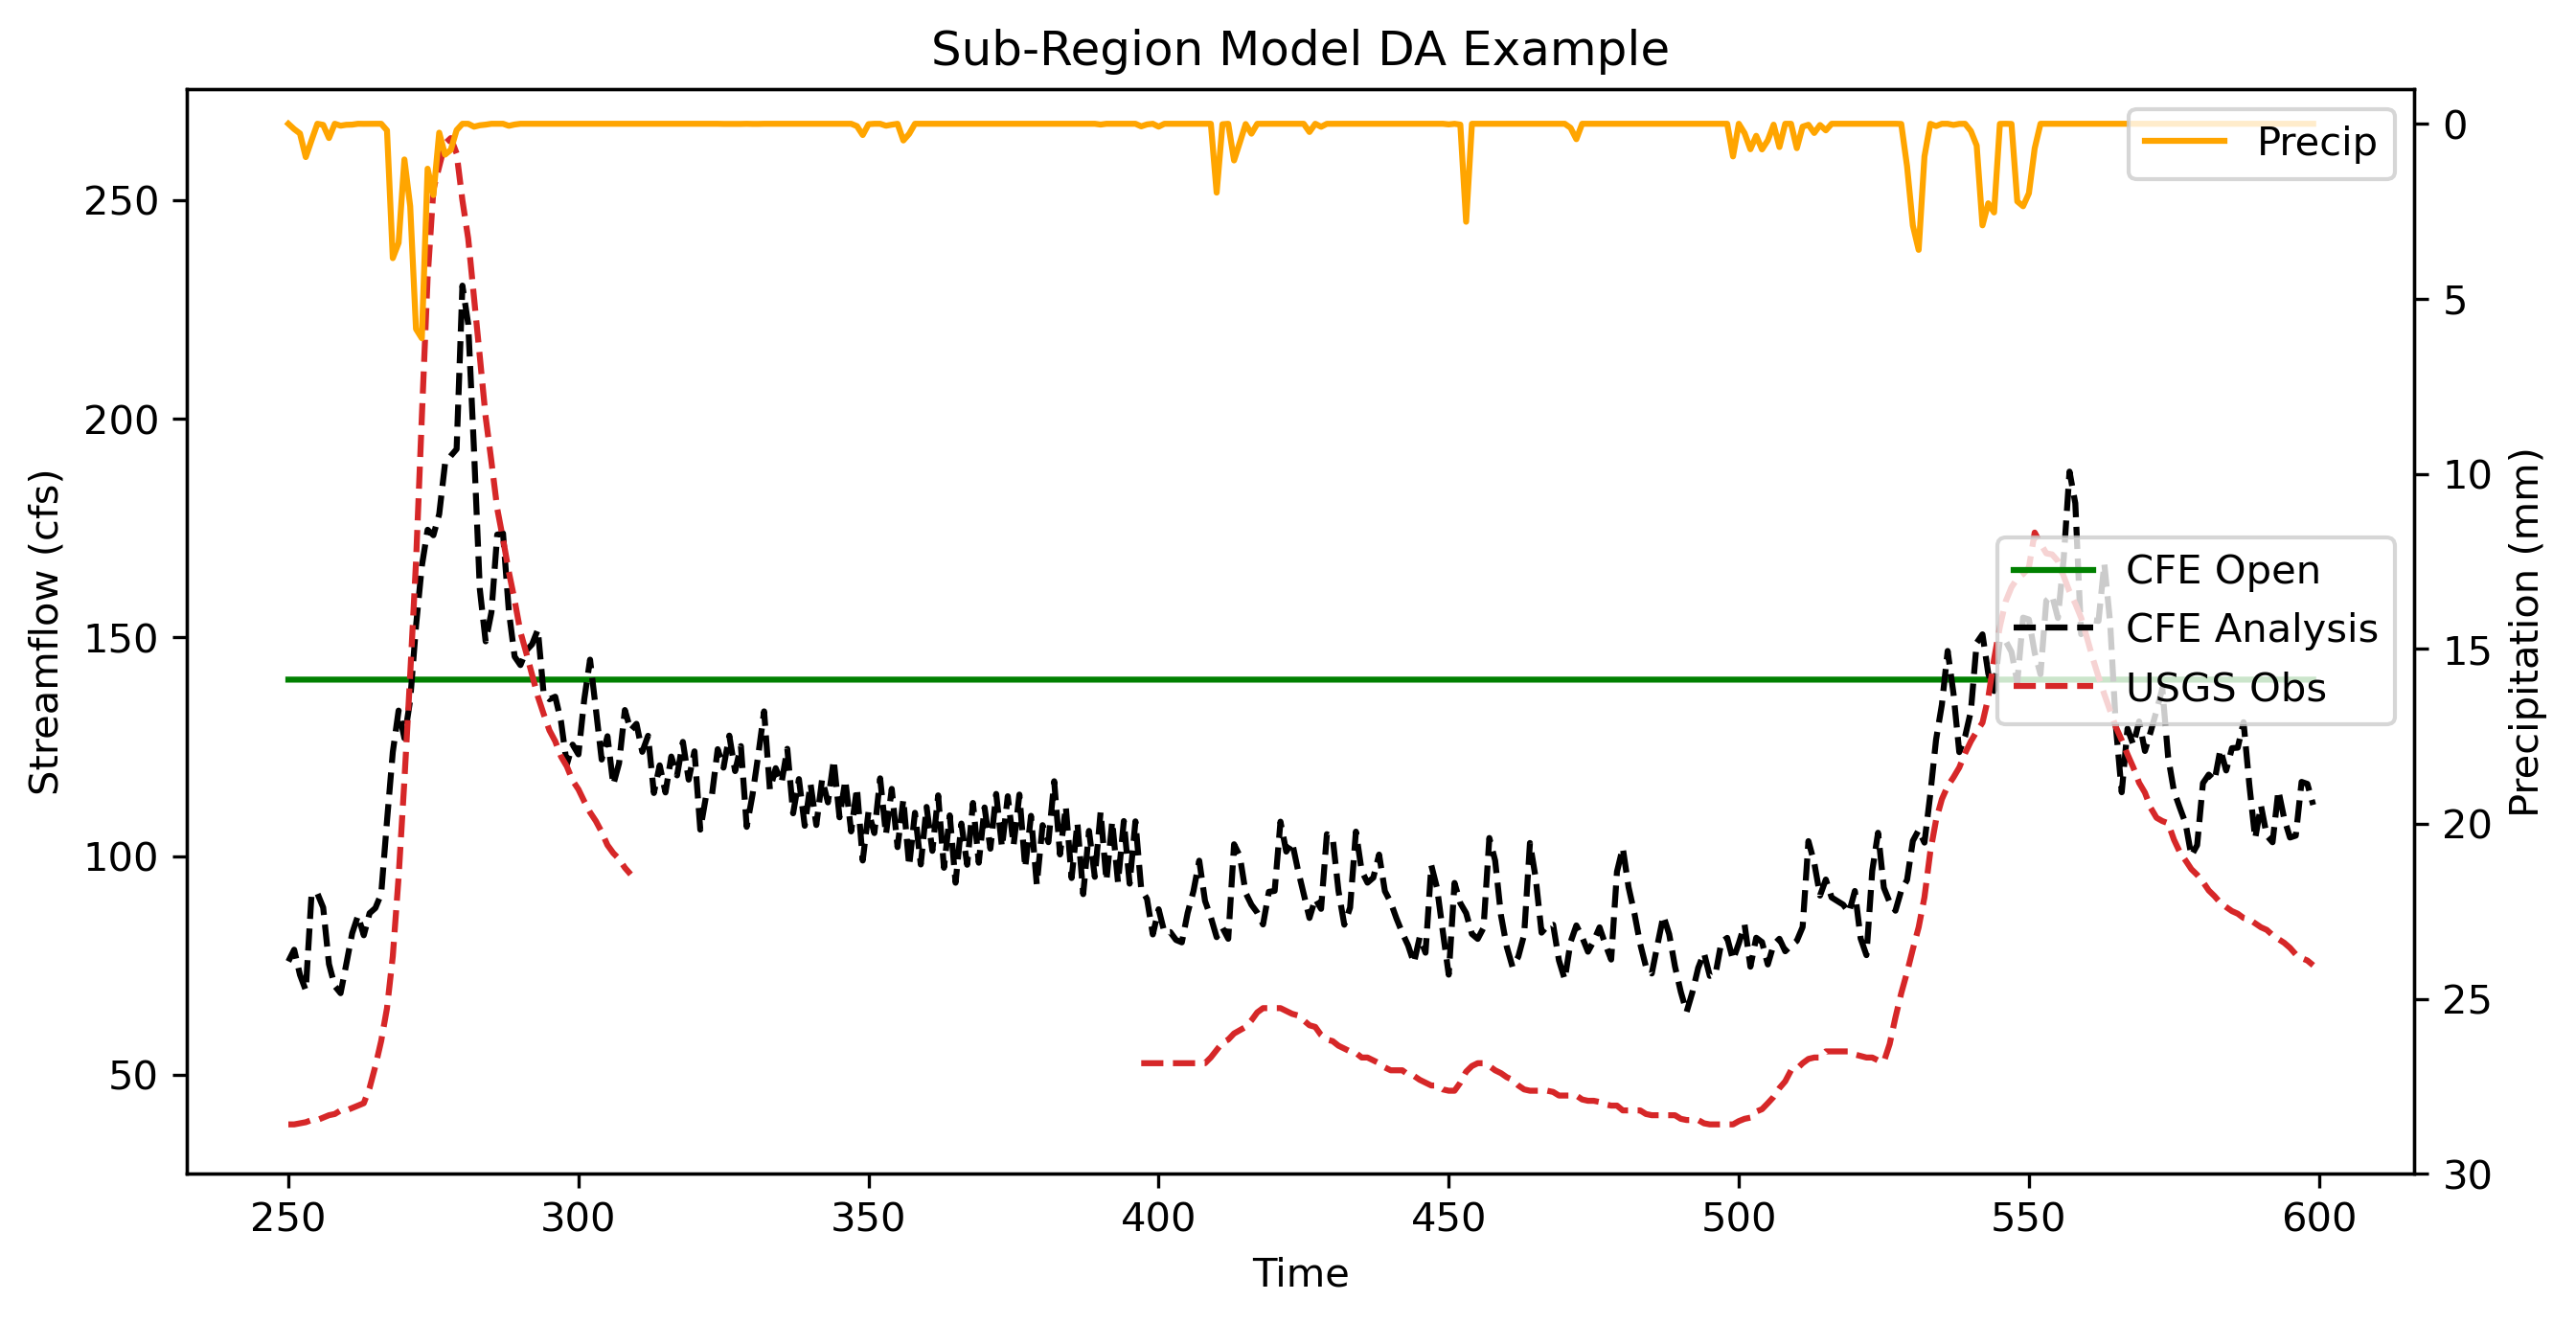

In [7]:
istart_plot=250
iend_plot=600
x = list(range(istart_plot, iend_plot))

fig, ax1 = plt.subplots(figsize = (10,5), dpi=300)

ax2 = ax1.twinx()

ax1.set_xlabel('Time')
ax1.set_ylabel('Streamflow (cfs)')
ax2.set_ylabel('Precipitation (mm)')
ax2.set_ylim(-1,30,1)
ax2.invert_yaxis()


plt.title('Sub-Region Model DA Example')
#ax1.plot(x, cfePeturbed[istart_plot:iend_plot], color = 'tab:orange', label = 'CFE Peturbed')
ax1.plot(x, cfeOpen[istart_plot:iend_plot], color = 'green', label = 'CFE Open')
ax1.plot(x, cfeAnalysis[istart_plot:iend_plot], color = 'black', linestyle='dashed', label = 'CFE Analysis')
ax1.plot(x, obs[istart_plot:iend_plot], color = 'tab:red', linestyle='dashed', label = 'USGS Obs')
#ax1.plot(x, cfeEnKF[istart_plot:iend_plot], color = 'tab:blue', label = 'EnKF')
ax2.plot(df_forcing['APCP_surface'][istart_plot:iend_plot], color="orange", label = 'Precip')
#plt.ylabel('Streamflow (CFS)')
#plt.xlabel('Time')
ax1.legend(loc='center right')
ax2.legend(loc='upper right')
#plt.savefig("WorkingDA_7-19.png")

plt.show()


In [8]:
len(cfeOpen)

768

In [9]:
len(cfeAnalysis)

768

In [10]:
len(obs)

768

In [11]:
df=pd.DataFrame({"obs":obs,"cfeAnalysis":cfeAnalysis,"cfeOpen":cfeOpen})

In [12]:
df.dropna(axis=0, inplace=True)
df.reset_index(drop=True, inplace=True)

In [13]:
# nse_open=he.evaluator(he.nse,np.array(obs),np.array(cfeOpen))
# nse_analysis=he.evaluator(he.nse,obs[istart_plot:iend_plot],cfeAnalysis[istart_plot:iend_plot])
# kge_open, r_open, alpha_open, beta_open = he.evaluator(he.kge, obs,cfeOpen)
# print(r_open[0])

In [14]:
# CFE open eval
nse_open=he.evaluator(he.nse,df["obs"],df["cfeOpen"])
pbias_open=he.evaluator(he.pbias,df["obs"],df["cfeOpen"])
kge_open, r_open, alpha_open, beta_open = he.evaluator(he.kge, df["obs"],df["cfeOpen"])
print("r_open=",r_open[0])
print("KGE_open=",kge_open[0])
print("NSE_open=", nse_open[0])
print("PBIAS_open=", pbias_open[0])

r_open= -0.14637456242691618
KGE_open= -7.795165491422972
NSE_open= -404.9815494899798
PBIAS_open= 52.218658318423735


In [15]:
# CFE Analysis
nse_analysis=he.evaluator(he.nse,df["obs"],df["cfeAnalysis"])
pbias_analysis=he.evaluator(he.pbias,df["obs"],df["cfeAnalysis"])
kge_analysis, r_analysis, alpha_analysis, beta_analysis = he.evaluator(he.kge, df["obs"],df["cfeAnalysis"])
print("r_analysis=",r_analysis[0])
print("KGE_analysis=",kge_analysis[0])
print("NSE_analysis=", nse_analysis[0])
print("PBIAS_analysis=", pbias_analysis[0])

r_analysis= 0.9380478531979183
KGE_analysis= 0.4339170617787408
NSE_analysis= -0.5661758102620009
PBIAS_analysis= 30.677622923345435


In [16]:
print("mean_obs=",np.mean(df["obs"]))
print("STD_obs=",np.std(df["obs"]))
print("mean_open=",np.mean(df["cfeOpen"]))
print("STD_open=",np.std(df["cfeOpen"]))
print("mean_analysis=",np.mean(df["cfeAnalysis"]))
print("STD_analysis=",np.std(df["cfeAnalysis"]))


mean_obs= 66.93546270718221
STD_obs= 40.45261101684418
mean_open= 140.0870305259587
STD_open= 4.168444322807014
mean_analysis= 96.55679093803599
STD_analysis= 27.48700958460872
